## Task 4.10
### Part 1: Instacart Analysis Final Report


#### Step 1 - Import the data set you exported in Exercise 4.9 into a new Jupyter notebook


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

# Define the path
path = r'C:\\Users\\mshhan\\Documents\\05-2024 Instacart Basket Analysis\\02 Data\\Prepared Data'

# Import the merged data set
df = pd.read_pickle(os.path.join(path, 'orders_products_customers_aggregated.pkl'))

# Display the first few rows of the dataframe to ensure it's loaded correctly
df.head()

,order_id,user_id,order_number,day_of_week,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,_merge_existing,...,first_name,last_name,gender,state,age,date_joined,n_dependants,marital_status,income,_merge
0,2539329,1,1,2,8,NaN,196,1,0,both,...,Linda,Nguyen,Female,Alabama,31,2/17/2019,3,married,40423,both
1,2398795,1,2,3,7,15.0,196,1,1,both,...,Linda,Nguyen,Female,Alabama,31,2/17/2019,3,married,40423,both
2,473747,1,3,3,12,21.0,196,1,1,both,...,Linda,Nguyen,Female,Alabama,31,2/17/2019,3,married,40423,both
3,2254736,1,4,4,7,29.0,196,1,1,both,...,Linda,Nguyen,Female,Alabama,31,2/17/2019,3,married,40423,both
4,431534,1,5,4,15,28.0,196,1,1,both,...,Linda,Nguyen,Female,Alabama,31,2/17/2019,3,married,40423,both


#### Step 2 - Consider any security implications that might exist for this new data

We will ensure no personally identifiable information (PII) is included in the analysis.

The dataset contains columns such as 'first_name' and 'last_name', which are PII. We will remove these columns for security.


In [3]:
# Check for columns containing PII
pii_columns = ['first_name', 'last_name']
df.drop(columns=pii_columns, inplace=True)

#### Step 3 - Create a regional segmentation of the data


In [4]:
# Define regions based on the 'state' column
def get_region(state):
    region_northeast = ['Maine', 'New Hampshire', 'Vermont', 'Massachusetts', 'Rhode Island', 'Connecticut', 'New York', 'New Jersey', 'Pennsylvania']
    region_midwest = ['Ohio', 'Michigan', 'Indiana', 'Wisconsin', 'Illinois', 'Minnesota', 'Iowa', 'Missouri', 'North Dakota', 'South Dakota', 'Nebraska', 'Kansas']
    region_south = ['Delaware', 'Maryland', 'Virginia', 'West Virginia', 'Kentucky', 'North Carolina', 'South Carolina', 'Tennessee', 'Georgia', 'Florida', 'Alabama', 'Mississippi', 'Arkansas', 'Louisiana', 'Texas', 'Oklahoma']
    region_west = ['Montana', 'Idaho', 'Wyoming', 'Colorado', 'New Mexico', 'Arizona', 'Utah', 'Nevada', 'Washington', 'Oregon', 'California', 'Alaska', 'Hawaii']
    
    if state in region_northeast:
        return 'Northeast'
    elif state in region_midwest:
        return 'Midwest'
    elif state in region_south:
        return 'South'
    elif state in region_west:
        return 'West'
    else:
        return 'Unknown'

# Apply the function to create a new 'Region' column
df['Region'] = df['state'].apply(get_region)


In [5]:
# Verify the new 'Region' column
df[['state', 'Region']].head(10)


,state,Region
0,Alabama,South
1,Alabama,South
2,Alabama,South
3,Alabama,South
4,Alabama,South
5,Alabama,South
6,Alabama,South
7,Alabama,South
8,Alabama,South
9,Alabama,South


#### Step 4 - Determine whether there’s a difference in spending habits between the different U.S. regions


In [6]:
# Determine average spending by region
spending_region = df.groupby('Region')['prices'].mean().reset_index()
spending_region


,Region,prices
0,Midwest,12.715947
1,Northeast,11.556554
2,South,12.245624
3,Unknown,11.381385
4,West,11.321539


#### Step 5 - Create an exclusion flag for low-activity customers


In [7]:
# Create an exclusion flag for low-activity customers (less than 5 orders)
df['exclusion_flag'] = df['order_number'] < 5

# Filter out low-activity customers
df_active = df[df['exclusion_flag'] == False]


#### Step 6 - Create a profiling variable based on age, income, certain goods, and number of dependents


In [10]:
# Create profiling variables
def create_profile(row):
    if row['age'] < 35 and row['n_dependants'] == 0:
        return 'Single adult'
    elif row['age'] < 35 and row['n_dependants'] > 0:
        return 'Young parent'
    elif row['age'] >= 35 and row['n_dependants'] > 0:
        return 'Parent'
    else:
        return 'Adult'

# Apply the function using .loc to avoid SettingWithCopyWarning
df_active.loc[:, 'Profile'] = df_active.apply(create_profile, axis=1)

# Display the first few rows to check the new profiling column
df_active[['age', 'n_dependants', 'Profile']].head()

,age,n_dependants,Profile
4,31,3,Young parent
5,31,3,Young parent
6,31,3,Young parent
7,31,3,Young parent
8,31,3,Young parent


#### Step 7 - Create an appropriate visualization to show the distribution of profiles


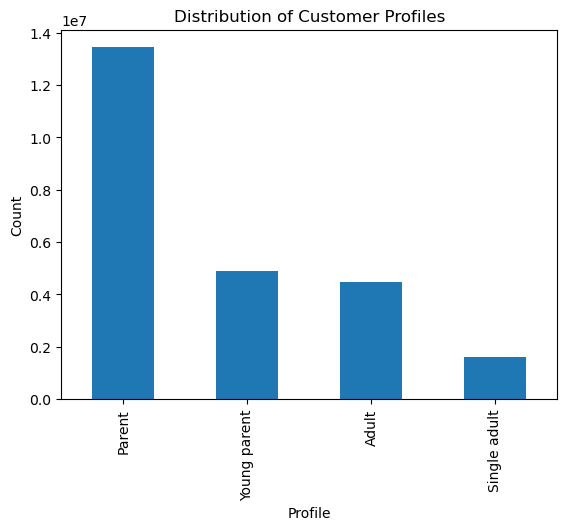

In [9]:
# Create a bar chart for the distribution of profiles
profile_distribution = df_active['Profile'].value_counts().plot.bar()
plt.title('Distribution of Customer Profiles')
plt.xlabel('Profile')
plt.ylabel('Count')
plt.show()


#### Step 8 - Aggregate the max, mean, and min variables on a customer-profile level for usage frequency and expenditure


In [11]:
# Aggregate the max, mean, and min for usage frequency and expenditure
profile_stats = df_active.groupby('Profile').agg({
    'order_number': ['max', 'mean', 'min'],
    'prices': ['max', 'mean', 'min']
}).reset_index()
profile_stats


Profile order_number                  prices                
                         max       mean min      max       mean  min
0         Adult           99  22.191319   5  99999.0  11.896472  1.0
1        Parent           99  21.881967   5  99999.0  11.691061  1.0
2  Single adult           99  21.845139   5  99999.0  12.402804  1.0
3  Young parent           99  21.948492   5  99999.0  11.959074  1.0

#### Step 9 - Compare your customer profiles with regions and departments


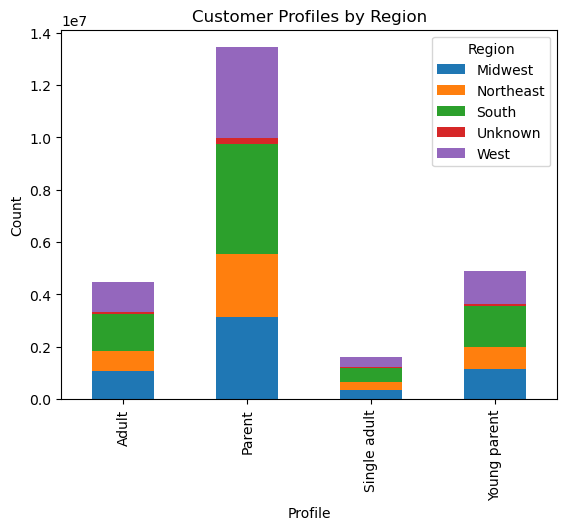

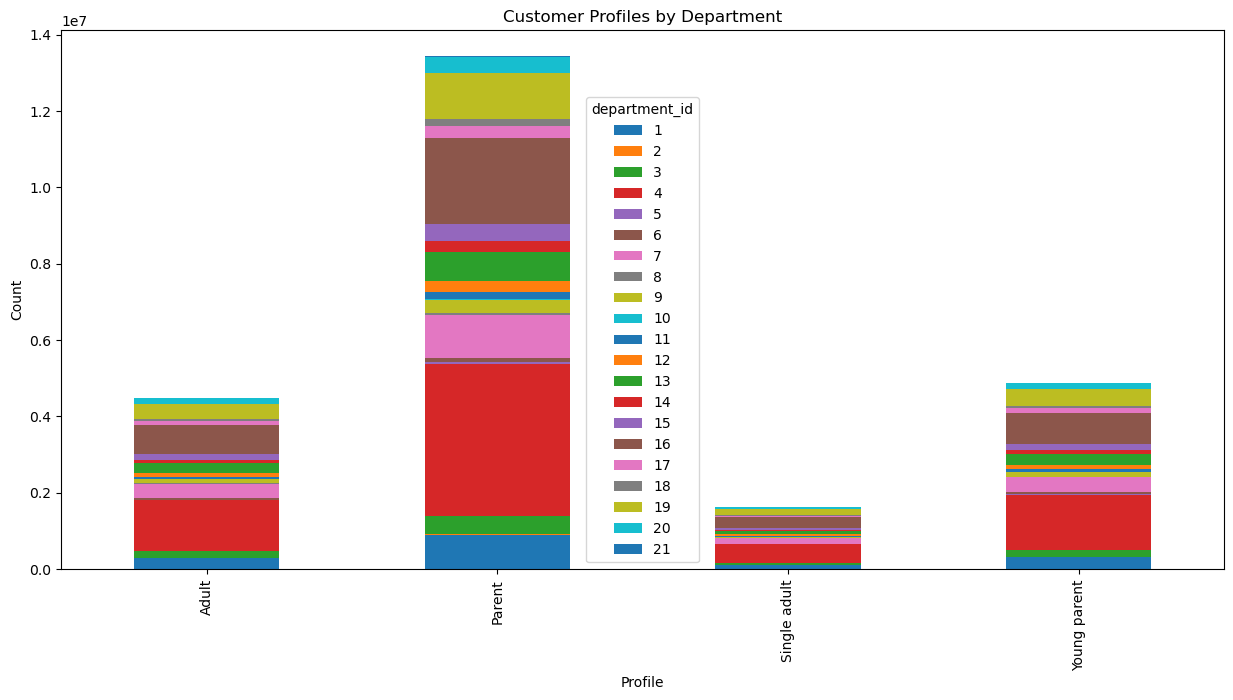

In [14]:
# Compare customer profiles with regions
profile_region = df_active.groupby(['Profile', 'Region']).size().unstack().plot(kind='bar', stacked=True)
plt.title('Customer Profiles by Region')
plt.xlabel('Profile')
plt.ylabel('Count')
plt.show()

# Compare customer profiles with departments
profile_department = df_active.groupby(['Profile', 'department_id']).size().unstack().plot(kind='bar', stacked=True, figsize=(15, 7))
plt.title('Customer Profiles by Department')
plt.xlabel('Profile')
plt.ylabel('Count')
plt.show()


#### Step 10 - Tidy up your script, export your final data set, and save your notebook


In [21]:
# Export the final data set
df_active.to_pickle(os.path.join(path, 'orders_products_customers_active.pkl'))


## Additional Visualizations


In [15]:
# Start creating unique user_id sample and take relevant columns
user_sample = df_active[['user_id', 'age', 'income', 'n_dependants', 'Region', 'order_number']]
# Remove duplicate rows in the user_sample to obtain a sample of all unique customers
user_sample = user_sample.drop_duplicates()
# Check data
user_sample.head()


,user_id,age,income,n_dependants,Region,order_number
4,1,31,40423,3,South,5
5,1,31,40423,3,South,6
6,1,31,40423,3,South,7
7,1,31,40423,3,South,8
8,1,31,40423,3,South,9


In [16]:
# Create age groups
def age_group(age):
    if age < 20:
        return 'Below 20'
    elif 20 <= age < 30:
        return '20-29'
    elif 30 <= age < 40:
        return '30-39'
    elif 40 <= age < 50:
        return '40-49'
    elif 50 <= age < 60:
        return '50-59'
    else:
        return '60 and above'
user_sample['age_group'] = user_sample['age'].apply(age_group)


In [17]:
# Create income groups
def income_group(income):
    if income < 40000:
        return 'Low'
    elif 40000 <= income < 80000:
        return 'Middle'
    else:
        return 'High'
user_sample['income_group'] = user_sample['income'].apply(income_group)


In [18]:
# Create dependants flag
user_sample['dependants_flag'] = user_sample['n_dependants'].apply(lambda x: 'With dependants' if x > 0 else 'No dependants')


In [19]:
# Check data
user_sample.head()


,user_id,age,income,n_dependants,Region,order_number,age_group,income_group,dependants_flag
4,1,31,40423,3,South,5,30-39,Middle,With dependants
5,1,31,40423,3,South,6,30-39,Middle,With dependants
6,1,31,40423,3,South,7,30-39,Middle,With dependants
7,1,31,40423,3,South,8,30-39,Middle,With dependants
8,1,31,40423,3,South,9,30-39,Middle,With dependants


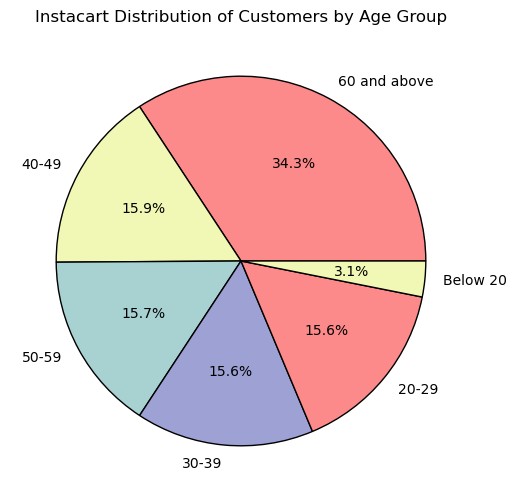

In [25]:
viz_path = r'C:\Users\mshhan\Documents\05-2024 Instacart Basket Analysis\04 Analysis\Visualizations'
# Pie chart for age groups
age_group_counts = user_sample['age_group'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(age_group_counts, 
        labels=age_group_counts.index, 
        autopct='%.1f%%', 
        colors=['#FD8A8A', '#F1F7B5', '#A8D1D1', '#9EA1D4'], 
        wedgeprops={'edgecolor': 'black'})
plt.title('Instacart Distribution of Customers by Age Group')
plt.savefig(os.path.join(viz_path, 'customers_age_groups_pie.png'), bbox_inches='tight')
plt.show()


The pie chart above shows the distribution of customers by age group. It helps in understanding the age demographics of Instacart's customer base.


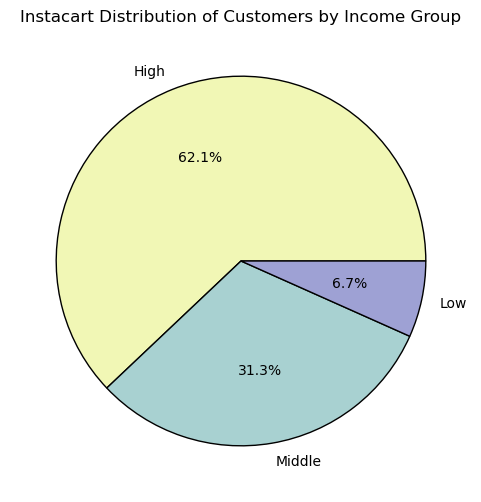

In [27]:
# Pie chart for income groups
income_group_counts = user_sample['income_group'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(income_group_counts, 
        labels=income_group_counts.index, 
        autopct='%.1f%%',
        colors=['#F1F7B5', '#A8D1D1', '#9EA1D4'],
        wedgeprops={'edgecolor': 'black'})
plt.title('Instacart Distribution of Customers by Income Group')
plt.savefig(os.path.join(viz_path, 'customers_income_groups_pie.png'), bbox_inches='tight')
plt.show()


The pie chart above shows the distribution of customers by income group. It provides insights into the income levels of Instacart's customers.


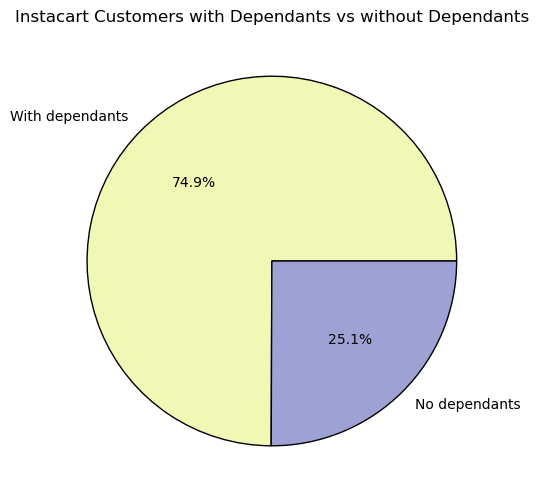

In [28]:
# Pie chart for dependants flag
dependants_flag_counts = user_sample['dependants_flag'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(dependants_flag_counts, 
        labels=dependants_flag_counts.index, 
        autopct='%.1f%%', 
        colors=['#F1F7B5', '#9EA1D4'],
        wedgeprops={'edgecolor': 'black'})
plt.title('Instacart Customers with Dependants vs without Dependants')
plt.savefig(os.path.join(viz_path, 'customers_dependants_pie.png'), bbox_inches='tight')
plt.show()


The pie chart above shows the distribution of customers with and without dependants. This helps in understanding the family status of Instacart's customers.


C:\Users\jainl\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


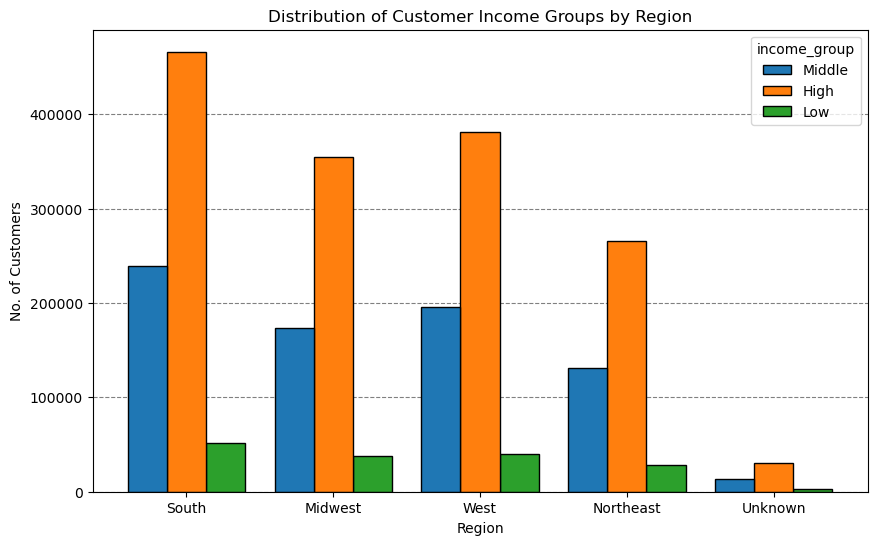

In [30]:
# Histogram for income group by region
plt.figure(figsize=(10, 6))
sns.histplot(data=user_sample, x='Region', hue='income_group', multiple='dodge', shrink=.8, alpha=1)
plt.gca().set_axisbelow(True)
plt.grid(axis='y', color='gray', linestyle='dashed')
plt.title('Distribution of Customer Income Groups by Region')
plt.ylabel('No. of Customers')
plt.xlabel('Region')
plt.savefig(os.path.join(viz_path, 'instacart_income_by_region.png'), bbox_inches='tight')
plt.show()


The histogram above shows the distribution of customer income groups across different regions. It helps in identifying regional income trends among Instacart's customers.


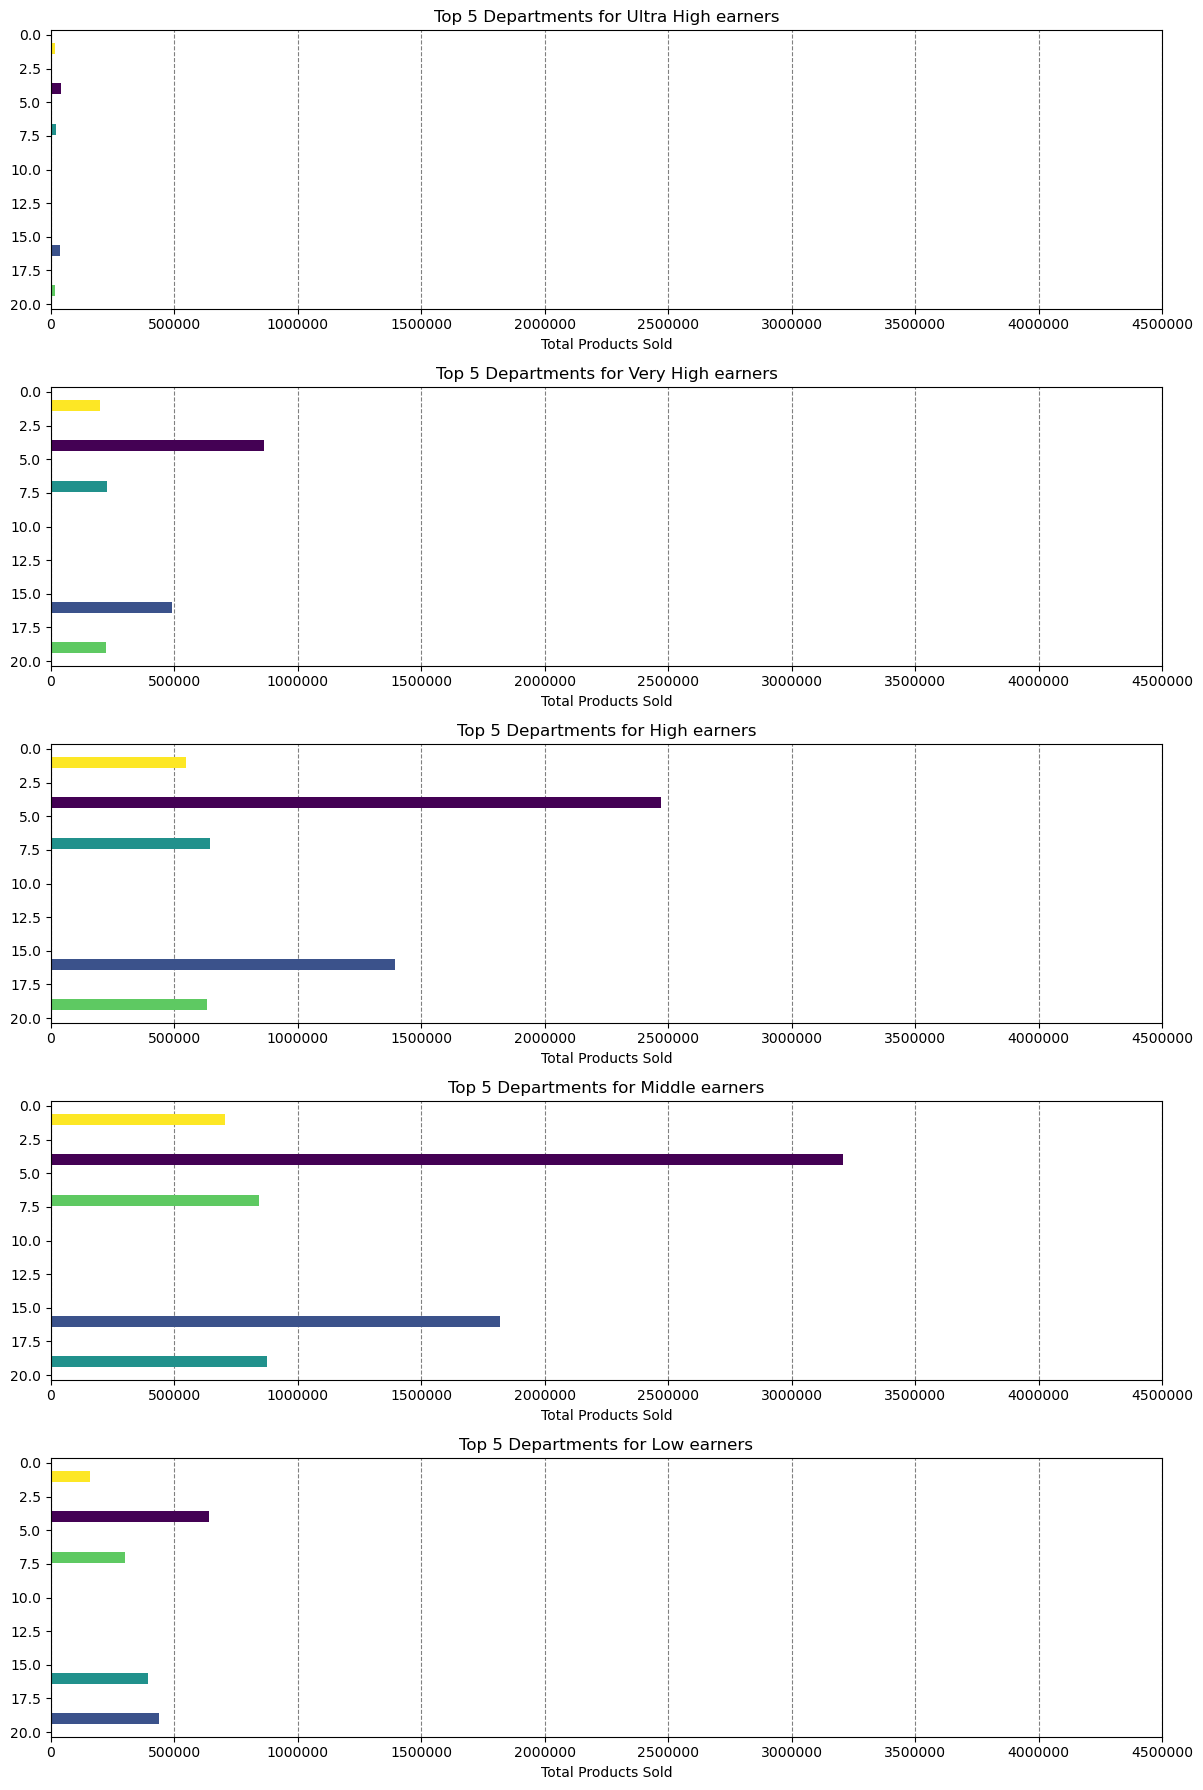

In [37]:
# Create income groups based on the 'income' column
df_active.loc[:, 'income_group'] = pd.cut(df_active['income'], 
                                          bins=[0, 50000, 100000, 150000, 200000, np.inf], 
                                          labels=['Low', 'Middle', 'High', 'Very High', 'Ultra High'])

# Group by income_group and department_id, count occurrences, and sort
income_department_counts = df_active.groupby(['income_group', 'department_id'], observed=False).size().reset_index(name='counts')
income_department_counts.sort_values(by=['income_group', 'counts'], ascending=False, inplace=True)

# Find unique income groups present in the data
unique_income_groups = income_department_counts['income_group'].unique()

# Create subplots and color scheme
fig, axs = plt.subplots(len(unique_income_groups), 1, figsize=(12, 18))
colors = plt.cm.viridis(np.linspace(0, 1, 5))  # Sets color palette

# Iterate over each unique income group and create a horizontal bar chart
for i, income_group in enumerate(unique_income_groups):
    income_data = income_department_counts[income_department_counts['income_group'] == income_group].head(5)
    ax = axs[i]
    ax.barh(income_data['department_id'], income_data['counts'], color=colors, zorder=2)
    ax.set_title(f'Top 5 Departments for {income_group} earners')
    ax.set_xlabel('Total Products Sold')
    ax.set_xlim(0, 4500000)  # Keep x-axis range consistent for comparisons
    ax.ticklabel_format(style='plain', axis='x')
    ax.set_ylabel('')
    ax.invert_yaxis()  # Invert y-axis to have the highest count at the top
    ax.grid(axis='x', color='gray', linestyle='dashed')

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.savefig(os.path.join(viz_path, 'instacart_top_departments_by_income_group.png'), bbox_inches='tight')
plt.show()



The series of horizontal bar charts above show the top 5 departments for each income group. These charts help in understanding which departments are most popular among different income groups.


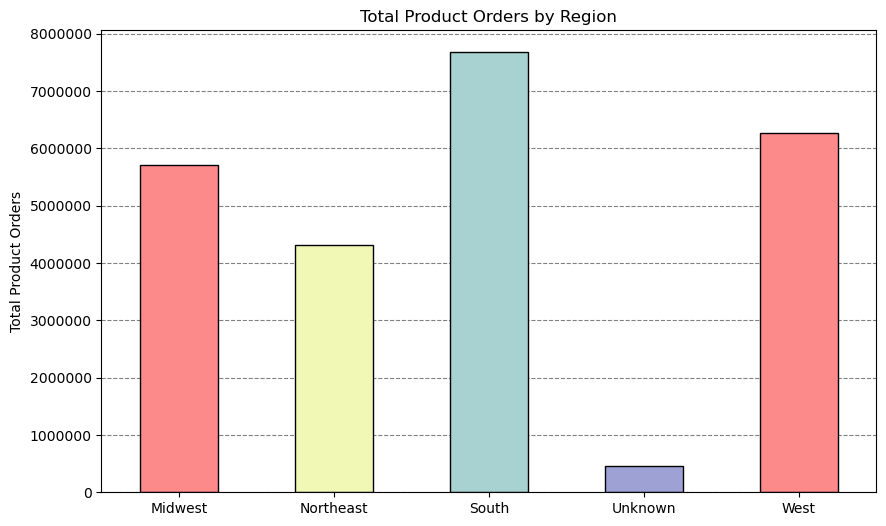

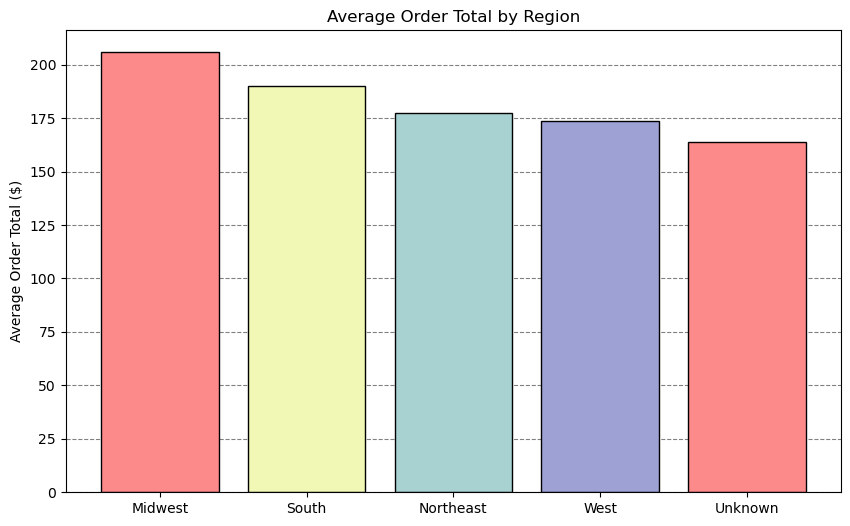

In [40]:
# Combine df_active with additional columns to create full_data
full_data = df_active.copy()

# Create histograms and visualizations

# Total Product Orders by Region
plt.figure(figsize=(10, 6))
plt.ticklabel_format(style='plain')
full_data['Region'].value_counts().sort_index().plot.bar(color=['#FD8A8A', '#F1F7B5', '#A8D1D1', '#9EA1D4'],
                                                         edgecolor='black', 
                                                         zorder=2, 
                                                         alpha=1)
plt.title("Total Product Orders by Region")
plt.xlabel("")
plt.xticks(rotation=0)
plt.ylabel("Total Product Orders")
plt.grid(axis='y', color='grey', linestyle='dashed')
plt.savefig(os.path.join(viz_path, 'instacart_total_orders_by_region.png'), bbox_inches='tight')
plt.show()

# Compute average order_total by Region
region_avg_order_total = df_active.groupby('Region')['order_total'].mean().sort_values(ascending=False).reset_index()

# Average Order Total by Region
plt.figure(figsize=(10, 6))
bars = plt.bar(region_avg_order_total['Region'], 
               region_avg_order_total['order_total'], 
               color=['#FD8A8A', '#F1F7B5', '#A8D1D1', '#9EA1D4'],
               edgecolor='black', 
               zorder=2, 
               alpha=1)
plt.title("Average Order Total by Region")
plt.xlabel("")
plt.xticks(rotation=0)
plt.ylabel("Average Order Total ($)")
plt.grid(axis='y', color='grey', linestyle='dashed')
plt.savefig(os.path.join(viz_path, 'instacart_average_order_by_region.png'), bbox_inches='tight')
plt.show()



The bar chart above shows the total product orders by region. It helps in understanding the volume of orders placed by customers from different regions.


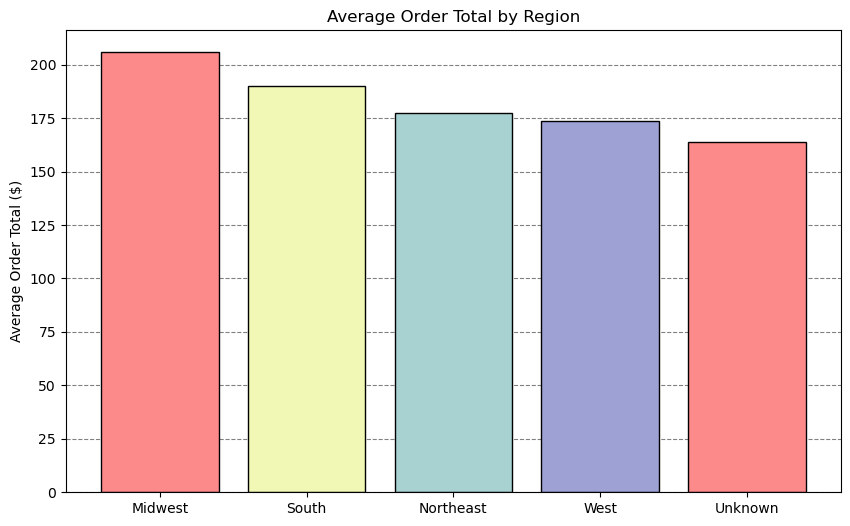

In [42]:
# Compute average order_total by region
region_avg_order_total = df_active.groupby('Region')['order_total'].mean().sort_values(ascending = False).reset_index()

# Check
region_avg_order_total

# Bar chart for average order total by region
plt.figure(figsize=(10, 6))
bars = plt.bar(region_avg_order_total['Region'], 
               region_avg_order_total['order_total'], 
               color = ['#FD8A8A', '#F1F7B5', '#A8D1D1', '#9EA1D4'],
               edgecolor='black', 
               zorder=2, 
               alpha = 1)
plt.title("Average Order Total by Region")
plt.xlabel("")
plt.xticks(rotation=0)
plt.ylabel("Average Order Total ($)")
plt.grid(axis = 'y', color = 'grey', linestyle = 'dashed')
plt.savefig(os.path.join(viz_path, 'instacart_average_order_by_region.png'), bbox_inches='tight')
plt.show()


The bar chart above shows the average order total by region. It helps in understanding the spending behavior of customers from different regions.


C:\Users\jainl\AppData\Local\Temp\ipykernel_7432\426001478.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sorted_df = df_active.groupby('income_group').agg({


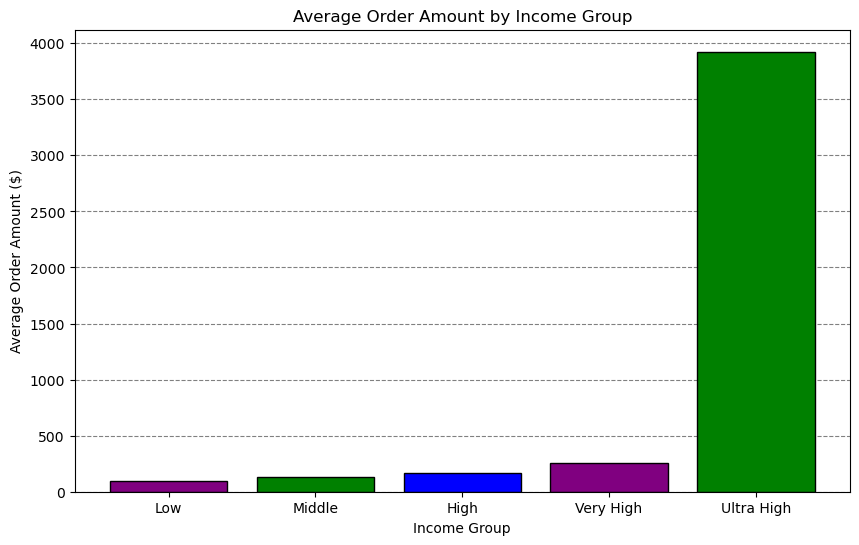

In [44]:
# Bar chart for average order amount by income group
sorted_df = df_active.groupby('income_group').agg({
    'order_total': 'mean'
}).sort_values(by='order_total', ascending=True).reset_index()

# Check
sorted_df

plt.figure(figsize=(10, 6))
plt.bar(sorted_df['income_group'], sorted_df['order_total'], color=['purple', 'green', 'blue'], zorder=2, edgecolor='black')
plt.xlabel('Income Group')
plt.ylabel('Average Order Amount ($)')
plt.title('Average Order Amount by Income Group')
plt.grid(axis = 'y', color = 'gray', linestyle = 'dashed')
plt.savefig(os.path.join(viz_path, 'instacart_average_order_amount_by_income.png'), bbox_inches='tight')
plt.show()


The bar chart above shows the average order amount by income group. It provides insights into the spending power of customers with different income levels.


<Figure size 800x1000 with 0 Axes>

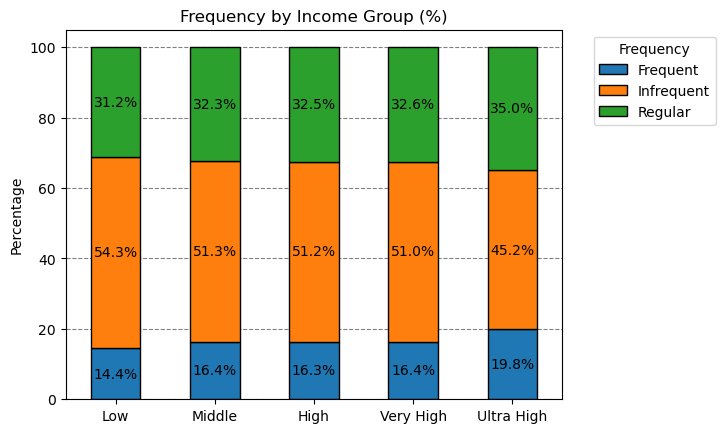

In [55]:
# Add age_group column
df_active.loc[:, 'age_group'] = pd.cut(df_active['age'], bins=[18, 35, 50, 65, 100], labels=['18-35', '36-50', '51-65', '66-100'], right=False)

# Add dependants_flag column
df_active.loc[:, 'dependants_flag'] = df_active['n_dependants'].apply(lambda x: 'With_dependants' if x > 0 else 'No_dependants')

# Add region column based on state
region_map = {
    'Northeast': ['Maine', 'New Hampshire', 'Vermont', 'Massachusetts', 'Rhode Island', 'Connecticut', 'New York', 'New Jersey', 'Pennsylvania'],
    'Midwest': ['Ohio', 'Indiana', 'Illinois', 'Michigan', 'Wisconsin', 'Minnesota', 'Iowa', 'Missouri', 'North Dakota', 'South Dakota', 'Nebraska', 'Kansas'],
    'South': ['Delaware', 'Maryland', 'District of Columbia', 'Virginia', 'West Virginia', 'North Carolina', 'South Carolina', 'Georgia', 'Florida', 'Kentucky', 'Tennessee', 'Mississippi', 'Alabama', 'Oklahoma', 'Texas', 'Arkansas', 'Louisiana'],
    'West': ['Idaho', 'Montana', 'Wyoming', 'Nevada', 'Utah', 'Colorado', 'Arizona', 'New Mexico', 'Alaska', 'Washington', 'Oregon', 'California', 'Hawaii']
}

def assign_region(state):
    for region, states in region_map.items():
        if state in states:
            return region
    return 'Other'

df_active.loc[:, 'region'] = df_active['state'].apply(assign_region)

# Add frequency_flag column
df_active.loc[:, 'frequency_flag'] = df_active['order_number'].apply(lambda x: 'Frequent' if x >= 20 else ('Regular' if 10 <= x < 20 else 'Infrequent'))

# Create user_sample from df_active
user_sample = df_active[['user_id', 'age_group', 'income_group', 'dependants_flag', 'region', 'frequency_flag']].drop_duplicates()

# Frequency by income group
crosstab1 = pd.crosstab(user_sample['income_group'], user_sample['frequency_flag'], dropna=False)
crosstab1_norm = crosstab1.div(crosstab1.sum(axis=1), axis=0) * 100

plt.figure(figsize=(8, 10))
ax = crosstab1_norm.plot(kind='bar', stacked=True, zorder=2, edgecolor='black')

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    percentage = f'{height:.1f}%'  # Format as percentage
    ax.text(x + width / 2, y + height / 2, percentage, ha='center', va='center')

plt.title('Frequency by Income Group (%)')
plt.xlabel('')
plt.xticks(rotation=0)
plt.ylabel('Percentage')
plt.grid(axis='y', color='gray', linestyle='dashed')
plt.legend(title='Frequency', loc='upper left', bbox_to_anchor=(1.05, 1))
plt.savefig(os.path.join(viz_path, 'instacart_customer_frequency_by_income.png'), bbox_inches='tight')
plt.show()



The stacked bar chart above shows the frequency of orders by income group, normalized to percentages. It provides insights into how often customers of different income levels place orders.
